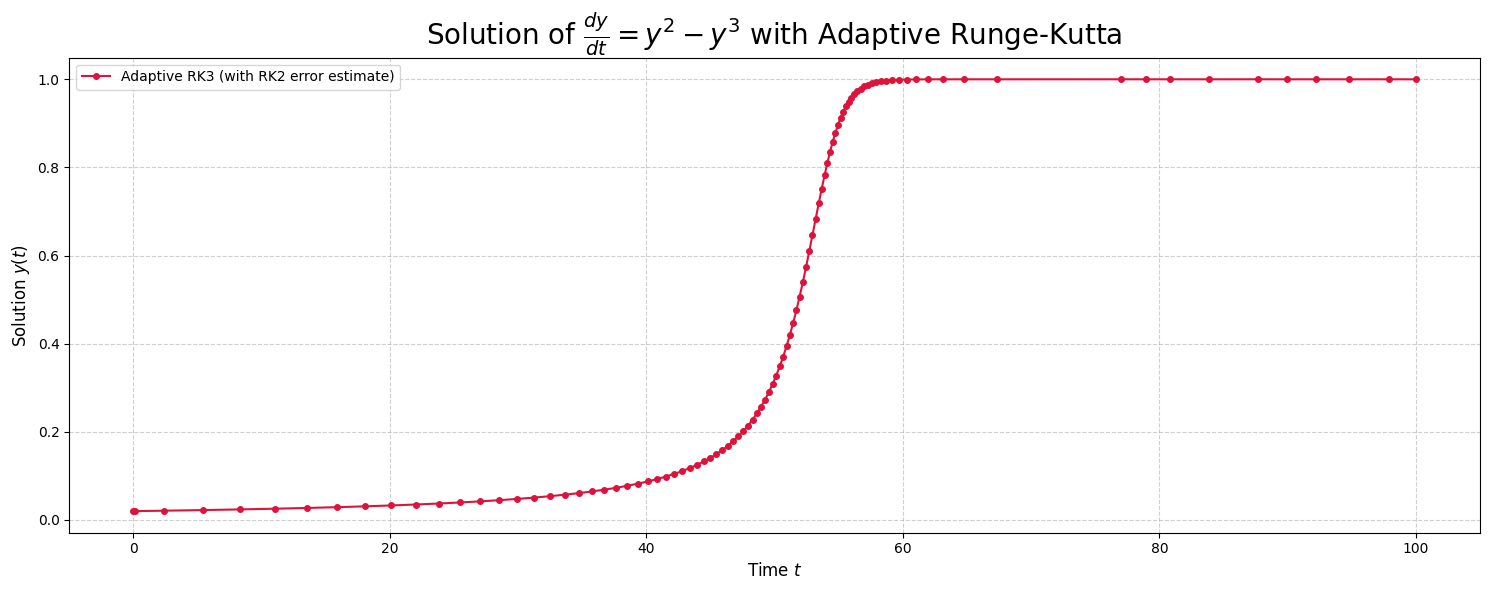

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def rk2_step(f,y,h,t):
    k1 = h * f(t, y)
    k2 = h * f(t + h, y + k1)
    return y + 0.5 * (k1 + k2)

def rk3_step(f, y, h, t):
    k1 = h * f(t, y)
    k2 = h * f(t + 0.5 * h, y + 0.5 * k1)
    k3 = h * f(t + h, y - k1 + 2 * k2)
    return y + (1/6) * (k1 + 4 * k2 + k3)

def adaptive_step(f, y0, t0, t_end, h_init, rtol = 1e-4, atol=1e-6):
    """
    Solves an ODE using adaptive step size with RK2 and Euler methods.

    Parameters:
    f: function - The derivative function dy/dt = f(t, y)
    y0: float or ndarray - Initial value
    t0: float - Initial time
    t_end: float - Final time
    h_init: float - Initial step size


    Returns:
    t_values: list - List of time values
    y_values: list - List of solution values
    """
    t_values = [t0]
    y_values = [y0]
    t = t0
    y = y0
    h = h_init

    while t < t_end:
        if t + h > t_end:
            h = t_end - t  # Adjust step size for the last step

        # Euler's method (first-order approximation)
        y_rk3 = rk3_step(f,y,h,t)

        # RK2 method (second-order approximation)
        y_rk2 = rk2_step(f,y,h,t)

        # Estimate error as the difference between RK2 and Euler's method
        error = np.abs(y_rk3 - y_rk2)

        tol = rtol*np.max(np.abs(y_rk2)) + atol
        # Check if error is within tolerance
        if error < tol:
            t += h
            y = y_rk3  # Use RK2 solution
            t_values.append(t)
            y_values.append(y)

        # Adjust step size based on error estimate
        h *= 0.9 * (tol / (error + 1e-10))**(1/3)  

    return np.array(t_values), np.array(y_values)


# Example usage
def u_x(t, y):
    return y**2-y**3


delta = 0.02
t0, t_end, y0, h_init = 0, 2/delta, delta, 0.1
t_values, y_values = adaptive_step(u_x, y0, t0, t_end, h_init)

plt.figure(figsize=(15, 6), dpi=100)
plt.plot(t_values, y_values, 'o-', color='crimson', markersize=4, label='Adaptive RK3 (with RK2 error estimate)')
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Solution $y(t)$', fontsize=12)
plt.title(r'Solution of $\frac{dy}{dt} = y^2 - y^3$ with Adaptive Runge-Kutta', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()
